<a href="https://colab.research.google.com/github/sidnascimento/stock_investing/blob/main/C%C3%B3pia_de_Projeto_bolsa_investimentos_absoluto_independente_RV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bibliotecas 

In [2]:
#importando as bibliotecas basica
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
 
sns.set()
 
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,9)
matplotlib.rcParams.update({'font.size':22})
 
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importando as bibliotecas da base de dados
!pip install yfinance --upgrade --no-cache-dir

import yfinance as yf
yf.pdr_override()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 8.1 MB/s 
     |████████████████████████████████| 62 kB 44.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Funções de análise

In [4]:
#ganho no dia
def day_profit (data_close,data_open):
  #vende na abertura e compra no fechamento
  #return  (data_open-data_close)/data_open
  return  1 - (data_close/data_open)

In [5]:
#ganho noite
def nigth_profit (data_close,data_open):
  #compra no fechamento e vende na abertura
  if data_close.shape[0]>1:
    df = pd.DataFrame(data=0,index=data_open.index.values,columns=data_open.columns)
    Op_compra = data_close.iloc[0:-1] #Exclui o ultimo dia
    Op_vende = data_open.iloc[1:]#Exclui o primeiro dia
    Op_compra.reset_index(inplace=True)
    Op_vende.reset_index(inplace=True)
    Op_compra['Date'] = Op_vende['Date']
    Op_compra.set_index('Date',inplace=True)
    Op_vende.set_index('Date',inplace=True)
    df.iloc[1:] = (Op_vende - Op_compra)/ Op_compra 
    return df
  else:
    return data_close - data_close



In [6]:
#ganho metodo
def method_profit (data_close,data_open):
  df_nigth = nigth_profit(data_close,data_open)
  df_day = day_profit(data_close,data_open)
  return df_nigth + df_day

In [7]:
#ganho condicional
def condicional_profit (data_close,data_open,cond_percentage = 0.01):
  df_nigth = nigth_profit(data_close,data_open)
  df_day = day_profit(data_close,data_open)
  df_condicional = df_nigth.copy()
  idx = df_nigth > cond_percentage
  df_condicional[idx] = df_nigth[idx] + df_day[idx]
  return df_condicional


In [8]:
#valorização da ação
def tricks_profit (data_close):
  #compra no fechamento e vende na abertura
  if data_close.shape[0]>1:
    df = pd.DataFrame(data = 1,index=data_close.index.values,columns=data_close.columns)
    Op_compra = data_close.iloc[0:-1] #Exclui o ultimo dia
    Op_vende = data_close.iloc[1:]#Exclui o primeiro dia
    Op_compra.reset_index(inplace=True)
    Op_vende.reset_index(inplace=True)
    Op_compra['Date'] = Op_vende['Date']
    Op_compra.set_index('Date',inplace=True)
    Op_vende.set_index('Date',inplace=True)
    df.iloc[1:] = Op_vende/Op_compra
    #df = Op_vende/Op_compra
    return df
  else:
    return data_close/data_close

In [9]:
#metodo de escolha das ações
#critérios:
#ganho no método dia
#ganho no método noite
#valorização da ação
#preço da ação

#def sort_stock (data_close,data_open,n_stocks,choose):
def sort_stock (data_close,data_open,limiar = 0.01, criterion_method = ['Day','Nigth']):
  #escolhe os ativos a serem operados
  columns_index = ['Day','Nigth','Nigth_STD','Method','Conditional','Profit','MobMm','MobAg','Cheap','W_day','W_nigth','W_Method','W_Conditional','W_Profit','Expensive']
  line_index = ['Day','Nigth','Method','Conditional','Profit','Price']
  df = pd.DataFrame(columns=columns_index)
  df_value = pd.DataFrame(columns=data_close.columns)
  df_value['Criterio'] = line_index
  df_value.set_index('Criterio',inplace=True)

  #ganho no método dia
  return_day = day_profit(data_close,data_open)
  return_day_sum = return_day.cumsum()

  #ganho no método noite
  return_nigth = nigth_profit(data_close,data_open)
  for col in return_nigth.columns:
    return_nigth[col][return_nigth[col] == return_nigth[col].max()] = return_nigth[col].mean()
  #return_nigth[return_nigth==return_nigth.max()] = 0
  return_nigth_sum = return_nigth.cumsum()
  
  ##########################################################################
  #alculo do método noite considerando o menos desvio padrão.
  df_std = return_nigth.std()
  df_std_norm = (df_std.max() - df_std)/ (df_std.max()-df_std.min())
  #df_std_norm.sort_values(ascending=False).head(10)

  df_nigth_sum = return_nigth.sum()
  ##df_nigth_sum_norm = (df_nigth_sum-df_nigth_sum.min())/ (df_nigth_sum.max()-df_nigth_sum.min())
  df_nigth_sum_norm = (df_nigth_sum)/ (df_nigth_sum.max())
  #df_nigth_sum_norm.sort_values(ascending=False).head(10)

  #df_sum_n_s = 0.75*df_nigth_sum_norm  + 0.25*df_std_norm
  df_sum_n_s = df_nigth_sum_norm  + df_std_norm
  #df['Nigth'] = df_sum_n_s.sort_values(ascending=False).index.values
  ###########################################################################

  #ganho no método
  return_method = return_day+return_nigth
  return_method_sum = return_method.cumsum()

  #metodo condicional
  
  idx = return_nigth > limiar
  return_method_condicional = return_nigth.copy()
  return_method_condicional[idx] = return_nigth[idx] + return_day[idx]
  return_method_condicional_sum = return_method_condicional.cumsum()

  #valorização da ação
  return_stock = data_close/data_close.iloc[0]

  df_value.loc['Day'] = return_day_sum.iloc[-1]
  df_value.loc['Nigth'] = return_nigth_sum.iloc[-1]
  df_value.loc['Method'] = return_method_sum.iloc[-1]
  df_value.loc['Conditional'] = return_method_condicional_sum.iloc[-1]
  df_value.loc['Profit'] = return_stock.iloc[-1]
  df_value.loc['Price'] = data_close.iloc[-1]
  df_value = df_value.T
  df_value_norm = (df_value - df_value.min())/(df_value.max()-df_value.min()) # normaliza os dados

  df['MobMm'] = df_value_norm[criterion_method].min(axis=1).sort_values(ascending=False).index.values
  #df['MobMm'] = df_value_norm[criterion_method].max(axis=1).sort_values(ascending=False).index.values
  df['MobAg'] = df_value_norm[criterion_method].sum(axis=1).sort_values(ascending=False).index.values

  df['Day'] = return_day_sum.iloc[-1].sort_values(ascending=False).index.values
  
  df['Nigth'] = return_nigth_sum.iloc[-1].sort_values(ascending=False).index.values
  df['Nigth_STD'] = df_sum_n_s.sort_values(ascending=False).index.values

  df['Method'] = return_method_sum.iloc[-1].sort_values(ascending=False).index.values
  df['Conditional'] = return_method_condicional_sum.iloc[-1].sort_values(ascending=False).index.values
  df['Profit'] = return_stock.iloc[-1].sort_values(ascending=False).index.values
  df['Cheap'] = data_close.iloc[-1].sort_values(ascending=True).index.values
  df['W_day'] = return_day_sum.iloc[-1].sort_values(ascending=True).index.values
  df['W_nigth'] = return_nigth_sum.iloc[-1].sort_values(ascending=True).index.values
  df['W_Method'] = return_method_sum.iloc[-1].sort_values(ascending=True).index.values
  df['W_Conditional'] = return_method_condicional_sum.iloc[-1].sort_values(ascending=True).index.values
  df['W_Profit'] = return_stock.iloc[-1].sort_values(ascending=True).index.values
  df['Expensive'] = data_close.iloc[-1].sort_values(ascending=False).index.values
  return df_value,df


In [10]:
def proft(stock,initial_date,final_date,data_close,data_open,stock_market_indice, cond_percentage=0.01,trade_percentage=0,leverage = 1):
  #df = pd.DataFrame(columns=['Return','Method','Day','Nigth','Conditional'])
  df = pd.DataFrame(columns=['Return','Method','Day','Nigth','Conditional','Trade','Index'])
  data_index = data_close.index[(data_close.index >=initial_date) & (data_close.index <=final_date)]
  #ganho da ação
  portfolio_proft = data_close.loc[data_index][stock]/data_close.loc[data_index[0]][stock]
  #portfolio_proft = portfolio_proft.mean(axis = 1)

  #Ganho no método
  portfolio_proft_day = day_profit(data_close.loc[data_index],data_open.loc[data_index])
  portfolio_proft_nigth = nigth_profit(data_close.loc[data_index],data_open.loc[data_index])
  portfolio_proft_nd = portfolio_proft_nigth[stock] + portfolio_proft_day[stock]

  #ganho condicional
  x = portfolio_proft_nigth[stock].mean(axis = 1)
  z = portfolio_proft_nigth[stock].mean(axis = 1)
  y = portfolio_proft_day[stock].mean(axis = 1)
  w = portfolio_proft_day[stock].mean(axis = 1)
  
  #Condicional
  idx = x < cond_percentage
  y[idx] = y[idx]*(-1)
  y = y+z
  df['Conditional'] = y.cumsum()+1

  #trade
  idx = x > trade_percentage
  z[idx] = z[idx] + w[idx]
  idx = x < 0
  z[idx] = z[idx] + w[idx]*(-1)
  df['Trade'] = z.cumsum()+1 

  #índice
  market_index = stock_market_indice[ibov.index>=initial_date]['Adj Close']
  market_index = market_index/market_index[0]
  df['Index'] = market_index

  #trade
  #t = portfolio_proft_day[stock].mean(axis = 1)
  #idx = x < percentage
  #t[idx] =  t[idx]*(-1)
  #df['Trade'] = t.cumsum()+1

  df['Return'] = portfolio_proft.mean(axis = 1)

  df['Method'] = portfolio_proft_nd.mean(axis = 1).cumsum()+1

  portfolio_proft_day = portfolio_proft_day*leverage
  df['Day'] = portfolio_proft_day[stock].mean(axis = 1).cumsum()+1
  
  df['Nigth'] = portfolio_proft_nigth[stock].mean(axis = 1).cumsum()+1

  return df

In [11]:
def stock_proft(stock,data_close,data_open,cond_percentage=0.01,trade_percentage=0.01,leverage = 1):
  df = pd.DataFrame(columns=['Return','Method','Day','Nigth','Conditional','Trade'])
  
  #ganho da ação
  portfolio_proft = tricks_profit (data_close)
  #Ganho dia
  portfolio_proft_day = day_profit(data_close,data_open)
  #Ganho noite
  portfolio_proft_nigth = nigth_profit(data_close,data_open)
  #ganho no método
  portfolio_proft_nd = portfolio_proft_nigth + portfolio_proft_day

  df['Return'] = portfolio_proft[stock].mean(axis = 1)

  df['Method'] = portfolio_proft_nd[stock].mean(axis = 1)

  df['Conditional'] = portfolio_proft_day[stock].mean(axis = 1)

  idx = df['Nigth'] < cond_percentage
  df['Conditional'][idx] = df['Conditional'][idx]*(-1)
  df['Conditional'] = df['Conditional'] + df['Nigth']

  portfolio_proft_day = portfolio_proft_day*leverage
  df['Day'] = portfolio_proft_day[stock].mean(axis = 1)
  
  df['Nigth'] = portfolio_proft_nigth[stock].mean(axis = 1)

  #trade
  df['Trade'] = df['Nigth'].copy()
  idx = df['Nigth'] > trade_percentage
  df['Trade'][idx] = df['Trade'][idx]+df['Day'][idx]
  
  #df['Trade'] = df['Day'].copy()
  #idx = df['Nigth'] < trade_percentage
  #df['Trade'][idx] = df['Day'][idx]*[-1]
  
  return df

# Baixando os dados do yahoo finance

In [12]:
#baixando os dados do ibovespa
year = '7y'
tricks_ibov = ['ALPA4.SA','ABEV3.SA','AMER3.SA','ASAI3.SA','AZUL4.SA','B3SA3.SA','BPAN4.SA','BBSE3.SA','BRML3.SA','BBDC3.SA','BBDC4.SA','BRAP4.SA','BBAS3.SA','BRKM5.SA','BRFS3.SA','BPAC11.SA','CRFB3.SA','CCRO3.SA','CMIG4.SA','CIEL3.SA','COGN3.SA','CPLE6.SA','CSAN3.SA','CPFE3.SA','CVCB3.SA','CYRE3.SA','DXCO3.SA','ECOR3.SA','ELET3.SA','ELET6.SA','EMBR3.SA','ENBR3.SA','ENGI11.SA','ENEV3.SA','EGIE3.SA','EQTL3.SA','EZTC3.SA','FLRY3.SA','GGBR4.SA','GOAU4.SA','GOLL4.SA','NTCO3.SA','SOMA3.SA','HAPV3.SA','HYPE3.SA','IGTI11.SA','IRBR3.SA','ITSA4.SA','ITUB4.SA','JBSS3.SA','JHSF3.SA','KLBN11.SA','RENT3.SA','LWSA3.SA','LREN3.SA','MGLU3.SA','MRFG3.SA','CASH3.SA','BEEF3.SA','MRVE3.SA','MULT3.SA','PCAR3.SA','PETR3.SA','PETR4.SA','PRIO3.SA','PETZ3.SA','QUAL3.SA','RADL3.SA','RDOR3.SA','RAIL3.SA','SBSP3.SA','SANB11.SA','CSNA3.SA','SULA11.SA','SUZB3.SA','TAEE11.SA','VIVT3.SA','TIMS3.SA','TOTS3.SA','UGPA3.SA','USIM5.SA','VALE3.SA','VBBR3.SA','VIIA3.SA','WEGE3.SA','YDUQ3.SA','MEAL3.SA']
#tricks_ibov = ['ALPA4.SA','ABEV3.SA','AMER3.SA','ASAI3.SA','AZUL4.SA','B3SA3.SA','BIDI4.SA','BIDI11.SA','BPAN4.SA','BBSE3.SA','BRML3.SA','BBDC3.SA','BBDC4.SA','BRAP4.SA','BBAS3.SA','BRKM5.SA','BRFS3.SA','BPAC11.SA','CRFB3.SA','CCRO3.SA','CMIG4.SA','CIEL3.SA','COGN3.SA','CPLE6.SA','CSAN3.SA','CPFE3.SA','CVCB3.SA','CYRE3.SA','DXCO3.SA','ECOR3.SA','ELET3.SA','ELET6.SA','EMBR3.SA','ENBR3.SA','ENGI11.SA','ENEV3.SA','EGIE3.SA','EQTL3.SA','EZTC3.SA','FLRY3.SA','GGBR4.SA','GOAU4.SA','GOLL4.SA','NTCO3.SA','SOMA3.SA','HAPV3.SA','HYPE3.SA','IGTI11.SA','IRBR3.SA','ITSA4.SA','ITUB4.SA','JBSS3.SA','JHSF3.SA','KLBN11.SA','RENT3.SA','LCAM3.SA','LWSA3.SA','LREN3.SA','MGLU3.SA','MRFG3.SA','CASH3.SA','BEEF3.SA','MRVE3.SA','MULT3.SA','PCAR3.SA','PETR3.SA','PETR4.SA','PRIO3.SA','PETZ3.SA','QUAL3.SA','RADL3.SA','RDOR3.SA','RAIL3.SA','SBSP3.SA','SANB11.SA','CSNA3.SA','SULA11.SA','SUZB3.SA','TAEE11.SA','VIVT3.SA','TIMS3.SA','TOTS3.SA','UGPA3.SA','USIM5.SA','VALE3.SA','VBBR3.SA','VIIA3.SA','WEGE3.SA','YDUQ3.SA','MEAL3.SA']
#tricks_ibov = ['ABEV3.SA','AZUL4.SA','B3SA3.SA','BBAS3.SA','BBDC3.SA','BBDC4.SA','BBSE3.SA','BEEF3.SA','BPAC11.SA','BRAP4.SA','BRDT3.SA','BRFS3.SA','BRKM5.SA','BRML3.SA','AMER3.SA','CCRO3.SA','CIEL3.SA','CMIG4.SA','COGN3.SA','CPFE3.SA','CPLE6.SA','CRFB3.SA','CSAN3.SA','CSNA3.SA','CVCB3.SA','CYRE3.SA','ECOR3.SA','EGIE3.SA','ELET3.SA','ELET6.SA','EMBR3.SA','ENBR3.SA','ENEV3.SA','ENGI11.SA','EQTL3.SA','EZTC3.SA','FLRY3.SA','GGBR4.SA','GNDI3.SA','GOAU4.SA','GOLL4.SA','HAPV3.SA','SOMA3.SA','HYPE3.SA','IGTA3.SA','IRBR3.SA','ITSA4.SA','ITUB4.SA','JBSS3.SA','JHSF3.SA','KLBN11.SA','MEAL3.SA','LAME4.SA','LCAM3.SA','LREN3.SA','MGLU3.SA','MRFG3.SA','MRVE3.SA','MULT3.SA','NTCO3.SA','PETR3.SA','PETR4.SA','PRIO3.SA','QUAL3.SA','RADL3.SA','RAIL3.SA','RENT3.SA','SANB11.SA','SBSP3.SA','SULA11.SA','SUZB3.SA','TAEE11.SA','TIMS3.SA','TOTS3.SA','UGPA3.SA','USIM5.SA','VALE3.SA','VIVT3.SA','VVAR3.SA','WEGE3.SA','YDUQ3.SA']#'PCAR3.SA',
dados_yahoo = yf.download(tickers =  tricks_ibov, period=year)

[*********************100%***********************]  87 of 87 completed


In [13]:

ibov = yf.download(tickers =  '^BVSP', period=year)

[*********************100%***********************]  1 of 1 completed


#Tratando os dados

In [14]:
#excluindo os dados faltantes
dados_yahoo.dropna(how='all',inplace=True)
#dados_yahoo.dropna(axis=1,inplace=True, thresh=247)
#if all(dados_yahoo.iloc[-1]['Open']==0):
#   dados_yahoo.drop(dados_yahoo.index[-1],inplace=True)
#dados_yahoo.drop(dados_yahoo.index[-1],inplace=True)

#dados_yahoo.index[-1]
dados_yahoo.head()


Adj Close                                                   \
             ABEV3.SA  ALPA4.SA   AMER3.SA ASAI3.SA AZUL4.SA  B3SA3.SA   
Date                                                                     
2015-12-21  14.749532  5.043907  13.522693      NaN      NaN  2.921710   
2015-12-22  14.832168  4.964304  13.342894      NaN      NaN  2.932278   
2015-12-23  15.038742  4.964304  13.816046      NaN      NaN  2.919069   
2015-12-28  14.989164  4.862991  14.128327      NaN      NaN  2.882086   
2015-12-29  15.038742  4.913647  14.402756      NaN      NaN  2.887369   

                                                      ...   Volume           \
             BBAS3.SA  BBDC3.SA  BBDC4.SA   BBSE3.SA  ... TIMS3.SA TOTS3.SA   
Date                                                  ...                     
2015-12-21  10.359482  7.519061  6.689537  14.657291  ...  2508600  2693708   
2015-12-22  10.422011  7.536983  6.749139  14.556123  ...  1627400  1242556   
2015-12-23  10.317791  7.626627  6.801732  14.776308  ...  2319700  1027047   
2015-12-28  10.408120  7.683995  6.868345  14.496614  ...  1416600  1093473   
2015-12-29  10.283052  7.673240  6.903407  14.341890  ...  2801600   954910   

                                                                              \
           UGPA3.SA  USIM5.SA VALE3.SA VBBR3.SA VIIA3.SA VIVT3.SA   WEGE3.SA   
Date                                                                           
2015-12-21  2707600  14054800  6942100      NaN    10000    16500  5074680.0   
2015-12-22  3139200   7315000  5677800      NaN     4500    19400  2987660.0   
2015-12-23  1580000   9877700  7174800      NaN     1400    25800  2621840.0   
2015-12-28  1315600   4390000  3095800      NaN      800    27300  2321800.0   
2015-12-29  1788600   4792600  2890100      NaN    25800    10900  5472740.0   

                     
           YDUQ3.SA  
Date                 
2015-12-21  1264100  
2015-12-22   638600  
2015-12-23   870600  
2015-12-28   821200  
2015-12-29   758600  

[5 rows x 522 columns]

In [15]:
# Dados de abertura e fechamento
data_open = dados_yahoo['Open']
data_close = dados_yahoo['Close']
data_High = dados_yahoo['High']
data_low = dados_yahoo['Low']

In [16]:
#Ajuste no formato das datas
data_open.reset_index(inplace=True)
data_open["Date"] = data_open["Date"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
data_open["Date"] = data_open["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data_open.set_index('Date',inplace=True)

data_close.reset_index(inplace=True)
data_close["Date"] = data_close["Date"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
data_close["Date"] = data_close["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data_close.set_index('Date',inplace=True)

data_High.reset_index(inplace=True)
data_High["Date"] = data_High["Date"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
data_High["Date"] = data_High["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data_High.set_index('Date',inplace=True)

data_low.reset_index(inplace=True)
data_low["Date"] = data_low["Date"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
data_low["Date"] = data_low["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data_low.set_index('Date',inplace=True)

In [17]:
#df_test = data_open.copy()#'2022-01-28 00:00:00'
#df_test.index[1]
#df_test.reset_index(inplace=True)
#df_test.index[1]
#df['DATE'] = df['Date'].datetime.date
#df['Date'].map(datetime.datetime.date) 
#df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
#df_test["Date"] = df_test["Date"].map(datetime.datetime.date) datetime.datetime.strptime
#df_test["Date"] = df_test["Date"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
#df_test["Date"] = df_test["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
#df_test.set_index('Date',inplace=True)
dados_yahoo.index

DatetimeIndex(['2015-12-21', '2015-12-22', '2015-12-23', '2015-12-28',
               '2015-12-29', '2015-12-30', '2016-01-04', '2016-01-05',
               '2016-01-06', '2016-01-07',
               ...
               '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09',
               '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-16', '2022-12-19'],
              dtype='datetime64[ns]', name='Date', length=1740, freq=None)

#Teste por metodos de escolha

In [18]:
def strategy_market(data_open,data_close,date_in,n_pass,n_fut,n_tricks,n_discard,choice,cond_percentage =0.01,trade_percentage=0,criterion_method=['Day','Nigth'],leverage = 1):
  date_operation = data_close.index
  n_trading = len(date_operation)
  date_in = datetime.datetime.strptime(date_in, '%Y-%m-%d %H:%M:%S')

  if len(date_operation[date_operation < date_in]) > n_pass:
    entry_point = len(date_operation[date_operation < date_in])
    date_in = date_operation[entry_point]
  else:
    entry_point = n_pass
    date_in = date_operation[entry_point]

  asset_development = pd.DataFrame()
  flag = True
  while flag:
    out_point = entry_point + n_fut
    if out_point > n_trading:
      out_point = n_trading
      flag = False

    pass_point = entry_point - n_pass
    idx_pas = date_operation[pass_point : entry_point]
    idx_fut = date_operation[entry_point : out_point]

    #df1, df2 = sort_stock (data_close.loc[idx_pas],data_open.loc[idx_pas])
    df1, df2 = sort_stock (data_close.loc[idx_pas],data_open.loc[idx_pas],criterion_method=criterion_method)
    stock = df2[choice][n_discard:n_discard+n_tricks]
    asset = stock_proft(stock,data_close.loc[idx_fut],data_open.loc[idx_fut],cond_percentage,trade_percentage,leverage)
    asset_development = pd.concat([asset_development,asset])
    entry_point = entry_point + n_fut

  asset_development['Return'] = asset_development['Return'].cumprod()
  asset_development['Method'] = asset_development['Method'].cumsum()+1
  asset_development['Day'] = asset_development['Day'].cumsum()+1
  asset_development['Nigth'] = asset_development['Nigth'].cumsum()+1
  asset_development['Conditional'] = asset_development['Conditional'].cumsum()+1
  asset_development['Trade'] = asset_development['Trade'].cumsum()+1

  market_index = ibov[ibov.index>=date_in]['Adj Close']
  market_index = market_index/market_index[0]
  asset_development['Index'] = market_index
  return asset_development

#Teste de estratégia

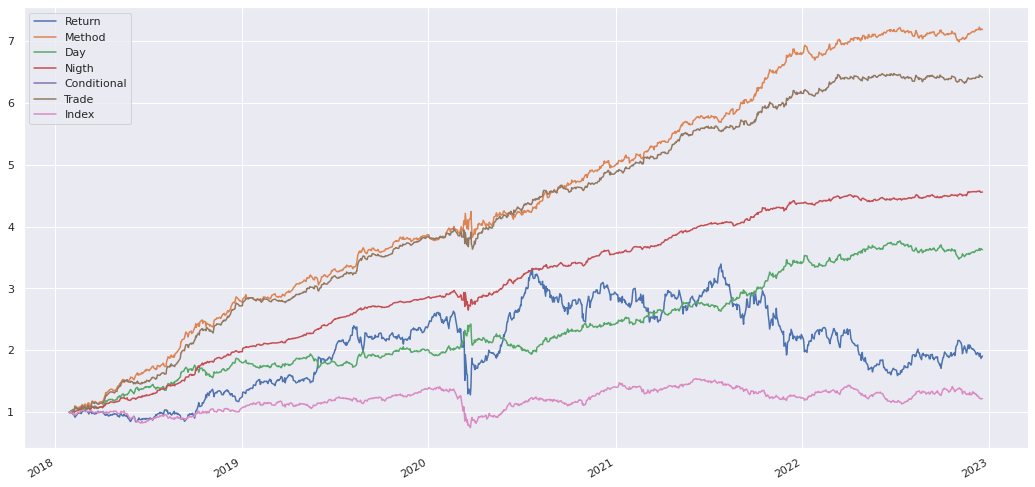

In [19]:
n_pass = 120 #dias avaliados
n_fut = 20 #dias aplicados
n_tricks = 4 #número de ações no portifólio
n_discard = 0 #descarte de ações
choice = 'Nigth' #['Day','Nigth','Nigth_STD','Method','Conditional','Profit','MobMm','MobAg','Cheap','W_day','W_nigth','W_Method','W_Conditional','W_Profit','Expensive']
#criterion_method = ['Day','Nigth','Method','Conditional']#['Day','Nigth','Method','Conditional']
#criterion_method = ['Day','Nigth','Method','Conditional']
criterion_method = ['Nigth','Day','Method']
date_in = '2018-01-28 00:00:00'
#date_in = '2020-09-01 00:00:00'
cond_percentage =0.01
trade_percentage=0.0
leverage = 1 #Alavancagem
 
asset_development = strategy_market(data_open,data_close,date_in,n_pass,n_fut,n_tricks,n_discard,choice,cond_percentage,trade_percentage,criterion_method,leverage)
#asset_development[['Return','Index']].plot()#['Return','Method','Day','Nigth','Conditional','Trade','Index']
asset_development.plot()

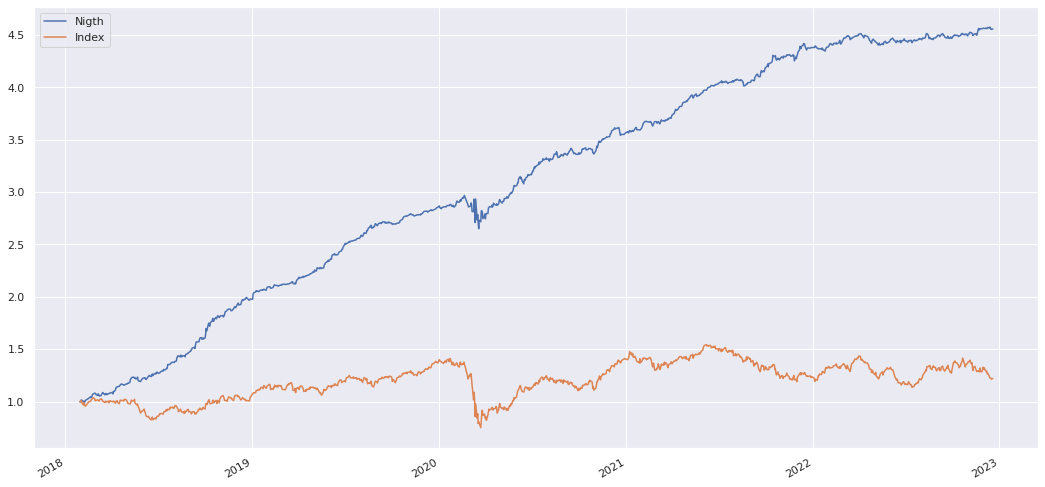

In [20]:
asset_development[['Nigth','Index']].plot()#['Return','Method','Day','Nigth','Conditional','Trade','Index']

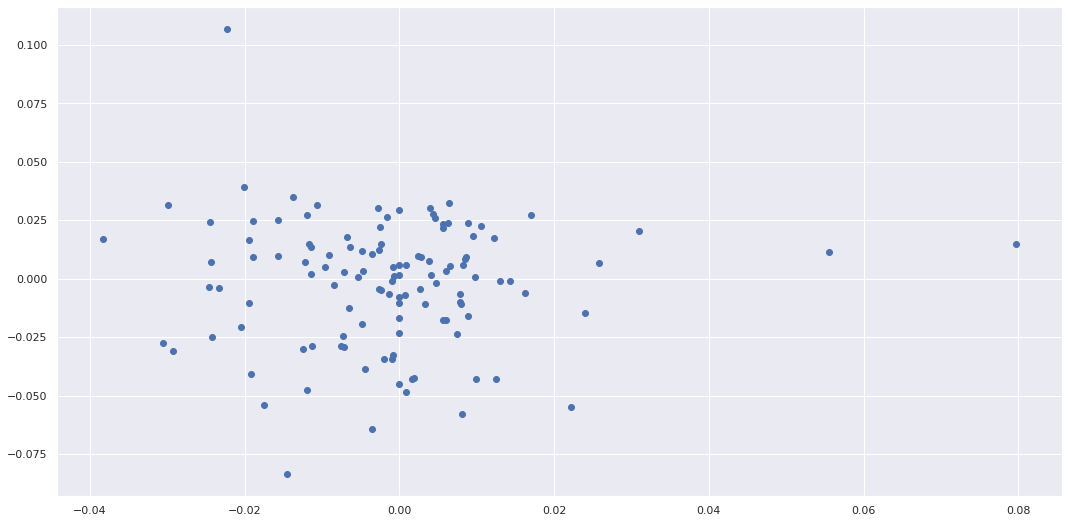

In [21]:
n_dias = 120
df1 = day_profit (data_close.iloc[-n_dias:-1],data_open[-n_dias:-1])
df2 = nigth_profit (data_close.iloc[-n_dias:-1],data_open[-n_dias:-1])
plt.scatter(df2['B3SA3.SA'],df1['B3SA3.SA'])
#df1.head()

#Escolha de portifólio

In [22]:
n_dias = 120
criterion_method = ['Day','Nigth','Method','Conditional']
#criterion_method = ['Profit','Nigth']
df1_tick_value, df2_choice_tick = sort_stock (data_close.iloc[-n_dias:-2],data_open[-n_dias:-2],criterion_method=criterion_method)
df2_choice_tick.head(20)

,Day,Nigth,Nigth_STD,Method,Conditional,Profit,MobMm,MobAg,Cheap,W_day,W_nigth,W_Method,W_Conditional,W_Profit,Expensive
0,IRBR3.SA,SUZB3.SA,SUZB3.SA,IRBR3.SA,MGLU3.SA,MEAL3.SA,AMER3.SA,CVCB3.SA,IRBR3.SA,MEAL3.SA,PETR4.SA,PETR4.SA,MRVE3.SA,IRBR3.SA,VALE3.SA
1,BRFS3.SA,MGLU3.SA,EGIE3.SA,BRFS3.SA,AMER3.SA,PRIO3.SA,PETZ3.SA,AMER3.SA,CASH3.SA,WEGE3.SA,PETR3.SA,B3SA3.SA,PCAR3.SA,QUAL3.SA,SBSP3.SA
2,QUAL3.SA,CVCB3.SA,MEAL3.SA,CVCB3.SA,CASH3.SA,WEGE3.SA,CVCB3.SA,BRFS3.SA,VIIA3.SA,PRIO3.SA,B3SA3.SA,MRVE3.SA,B3SA3.SA,BRFS3.SA,SUZB3.SA
3,CVCB3.SA,MEAL3.SA,EQTL3.SA,BRKM5.SA,PETZ3.SA,GOAU4.SA,BRKM5.SA,BRKM5.SA,COGN3.SA,ASAI3.SA,RDOR3.SA,RADL3.SA,ENGI11.SA,CVCB3.SA,RENT3.SA
4,BRKM5.SA,PRIO3.SA,VIVT3.SA,MRFG3.SA,CVCB3.SA,ASAI3.SA,YDUQ3.SA,MRFG3.SA,MGLU3.SA,LWSA3.SA,EZTC3.SA,WEGE3.SA,PETR4.SA,PETZ3.SA,ELET6.SA
5,MRFG3.SA,YDUQ3.SA,CVCB3.SA,QUAL3.SA,YDUQ3.SA,SBSP3.SA,BRFS3.SA,IRBR3.SA,MEAL3.SA,BBSE3.SA,JHSF3.SA,ASAI3.SA,EZTC3.SA,AMER3.SA,HYPE3.SA
6,AMER3.SA,BRKM5.SA,YDUQ3.SA,AMER3.SA,AZUL4.SA,GGBR4.SA,MRFG3.SA,PETZ3.SA,CVCB3.SA,GOAU4.SA,PCAR3.SA,PETR3.SA,HAPV3.SA,MRFG3.SA,ENGI11.SA
7,PETZ3.SA,MRFG3.SA,KLBN11.SA,PETZ3.SA,VIIA3.SA,BBSE3.SA,VIVT3.SA,YDUQ3.SA,ECOR3.SA,RADL3.SA,MRVE3.SA,LWSA3.SA,QUAL3.SA,BRKM5.SA,ELET3.SA
8,JBSS3.SA,EQTL3.SA,CPFE3.SA,YDUQ3.SA,SUZB3.SA,CIEL3.SA,AZUL4.SA,MGLU3.SA,HAPV3.SA,MRVE3.SA,ENGI11.SA,BBSE3.SA,JHSF3.SA,JBSS3.SA,VIVT3.SA
9,YDUQ3.SA,EGIE3.SA,MRFG3.SA,JBSS3.SA,BRKM5.SA,LWSA3.SA,EGIE3.SA,AZUL4.SA,CIEL3.SA,B3SA3.SA,RADL3.SA,EZTC3.SA,FLRY3.SA,GOLL4.SA,WEGE3.SA


In [23]:
mtdo = 'Nigth'#['Nigth','Profit','Method','MobAg']
df2_choice_tick[mtdo].head(10)

0    SUZB3.SA
1    MGLU3.SA
2    CVCB3.SA
3    MEAL3.SA
4    PRIO3.SA
5    YDUQ3.SA
6    BRKM5.SA
7    MRFG3.SA
8    EQTL3.SA
9    EGIE3.SA
Name: Nigth, dtype: object

#Avaliação do Portifólio


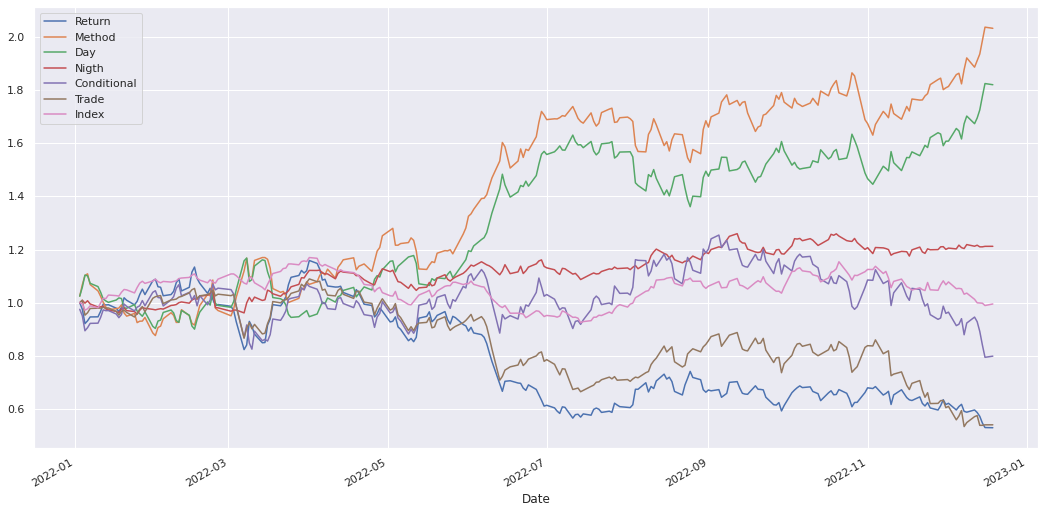

In [33]:
#stock = [ 'B3SA3.SA']# MEAL3 Avaliação unitária
#stock = [ 'SUZB3.SA', 'PRIO3.SA','CVCB3.SA','VIVT3.SA' ]#Nigth date_time 25/11/2022
#stock = [ 'CIEL3.SA', 'ELET6.SA','ASAI3.SA','ELET3.SA'  ]#Proft
#stock = [ 'CASH3.SA', 'GOLL4.SA','PETZ3.SA','AZUL4.SA'  ]#Method
#stock = [ 'CASH3.SA', 'GOLL4.SA','AMER3.SA','PETZ3.SA' ]#MobAg
#stock = [ 'SUZB3.SA', 'PRIO3.SA','CVCB3.SA','VIVT3.SA' ]#Fabricia 05/12/2022
#stock = [ 'PRIO3.SA', 'GGBR4.SA','SUZB3.SA','BRKM5.SA' ]#Sidnei date_time 12/09/2022##[ 'PRIO3.SA', 'GGBR4.SA','NTCO3.SA','BRKM5.SA' ]#Sidnei date_time 24/05/2022
#stock = [ 'BPAN4.SA','CASH3.SA','AMER3.SA','AZUL4.SA','BIDI11.SA','BIDI4.SA' ]#teste
stock = [ 'CVCB3.SA', 'GGBR4.SA','GOLL4.SA','GOLL4.SA' ]#teste
#stock = [ 'IRBR3.SA', 'CASH3.SA','VIIA3.SA','CVCB3.SA' ]#cheap[ 'COGN3.SA', 'MGLU3.SA','ECOR3.SA','CIEL3.SA', 'CVCB3.SA' ]
#initial_date = '2020-03-22 00:00:00';
#final_date = '2021-03-28 00:00:00';
initial_date = '2022-01-01 00:00:00';
final_date = '2023-01-10 00:00:00';
percentage = 0.01
leverage = 3 #Alavancagem
portfolio_proft = proft(stock,initial_date,final_date,data_close,data_open,ibov,percentage,leverage)
portfolio_proft.plot()#['Return','Method','Day','Nigth','Conditional','Trade','Index']
#portfolio_proft[['Return','Method','Day','Conditional','Trade','Index',]].plot()
#dados_yahoo.columns#,'YDUQ3.SA'

In [25]:
tick_value = data_close[stock].iloc[-1]
qt = tick_value.max()/tick_value
qt = qt.round()*100
inves = qt*tick_value
inves.sum()

12126.999950408936

#Funções para análise real

In [26]:
#ganho absoluto no dia
def absolut_day_profit (data_close,data_open,stock,stock_lot):
  #vende na abertura e compra no fechamento
  df = data_open[stock]-data_close[stock]
  df = df*stock_lot
  return  df.sum(axis = 1)

In [27]:
#ganho absoluto noite
def absolut_nigth_profit (data_close,data_open,stock,stock_lot):
  #compra no fechamento e vende na abertura
  if data_close.shape[0]>1:
    df = pd.DataFrame(data=0,index=data_open.index.values,columns=data_open.columns)
    Op_compra = data_close.iloc[0:-1] #Exclui o ultimo dia
    Op_vende = data_open.iloc[1:]#Exclui o primeiro dia
    Op_compra.reset_index(inplace=True)
    Op_vende.reset_index(inplace=True)
    Op_compra['Date'] = Op_vende['Date']
    Op_compra.set_index('Date',inplace=True)
    Op_vende.set_index('Date',inplace=True)
    df.iloc[1:] = (Op_vende - Op_compra)
    df1 = df[stock]*stock_lot
    return df1.sum(axis = 1)
  else:
    return [(data_close[stock] - data_close[stock])*stock_lot].sum(axis = 1)

In [28]:
initial_date = '2022-01-01 00:00:00';
final_date = '2022-12-28 00:00:00';
#stock = [ 'CSNA3.SA', 'GGBR4.SA','NTCO3.SA','GOAU4.SA' ]#Fabricia
#stock_lot = [ 500, 300, 500, 800]#noite120
stock = [ 'PRIO3.SA', 'GGBR4.SA','NTCO3.SA','BRKM5.SA' ]#noite
stock_lot = [ 400, 400, 600, 200]#noite120
#stock_lot = [200]#noite120
data_index = data_close.index[(data_close.index >=initial_date) & (data_close.index <=final_date)]
#df = absolut_day_profit (data_close.loc[data_index],data_open.loc[data_index],stock,stock_lot)
df_abs_nigth = absolut_nigth_profit (data_close.loc[data_index],data_open.loc[data_index],stock,stock_lot)
df_abs_day = absolut_day_profit (data_close.loc[data_index],data_open.loc[data_index],stock,stock_lot)

In [29]:
df = pd.DataFrame()
df['nigth'] = df_abs_nigth.copy() 
df['day'] = df_abs_day.copy() 
df['proft'] = df['nigth']+df['day']

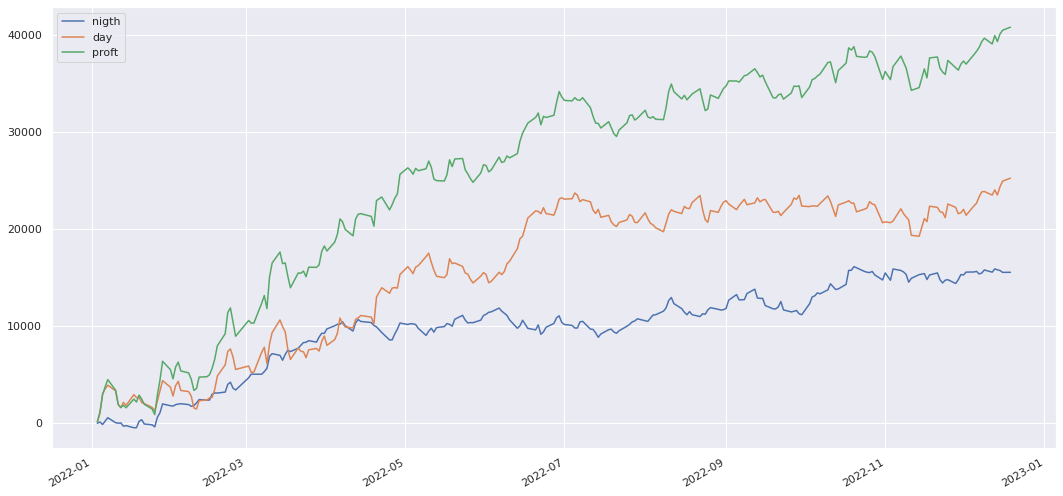

In [30]:
df.cumsum().plot()

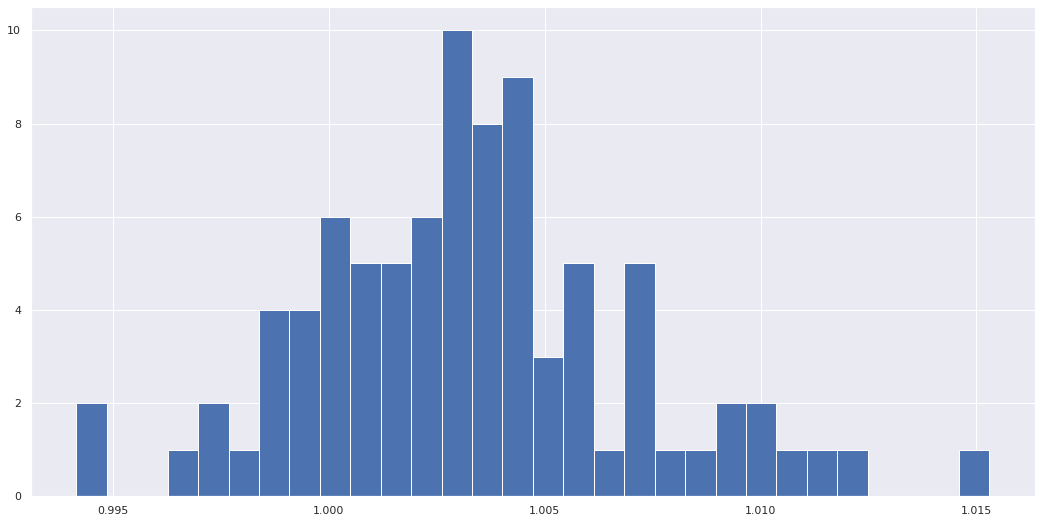

In [31]:
#tricks_profit (data_close.loc[ data_close.index>date_in ])
#nigth_profit (data_close,data_open)
#day_profit (data_close,data_open)
data_entrada='2021-05-01 00:00:00'
data_saida='2021-06-01 00:00:00'
date_1 = datetime.datetime.strptime(data_entrada, '%Y-%m-%d %H:%M:%S')
date_2 = datetime.datetime.strptime(data_saida, '%Y-%m-%d %H:%M:%S')
data_avaliada = (data_close.index>=date_1) & (data_close.index<=date_2)
ganho_acao = tricks_profit (data_close.loc[ data_avaliada ])
#ganho_noite = nigth_profit (data_close.loc[ data_avaliada ],data_open.loc[ data_avaliada ])
ganho_acao.mean().sort_values(ascending=False).hist(bins=30)